MBRL vs MFRL Comparison Demo
Training DreamerV3 Simplified...


/usr/local/lib/python3.12/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.12/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Training PPO Simplified...


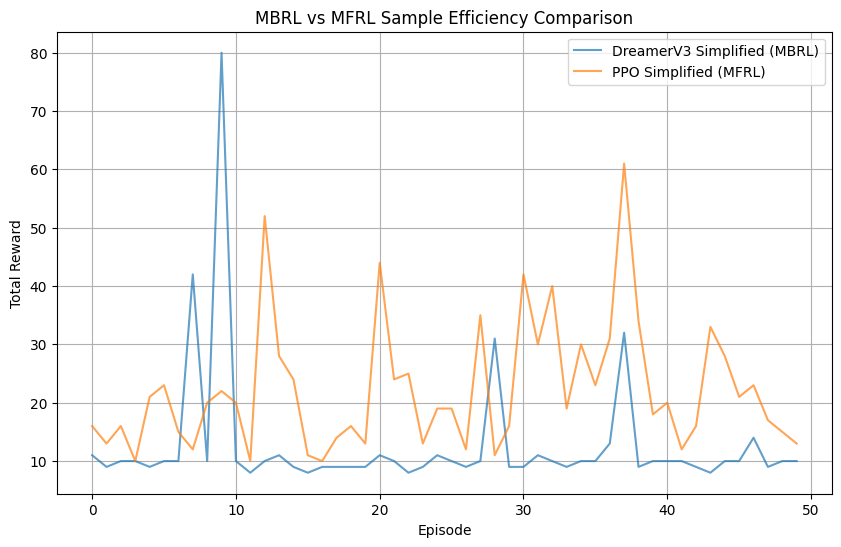


Generating Animation Demo
[DREAMER] Animation Episode Length: 10 steps


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


DreamerV3 Simplified animation generated.


[PPO] Animation Episode Length: 29 steps


/usr/local/lib/python3.12/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.12/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


PPO Simplified animation generated.



Statistics
DreamerV3 Average Reward: 12.68
PPO Average Reward: 22.20
DreamerV3 Max Reward: 80.0
PPO Max Reward: 61.0


In [12]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
# New imports for animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display
import io
from PIL import Image

# ==============================================================================
# Compatibility Fix
# Fix: AttributeError: module 'numpy' has no attribute 'bool8'
# This issue usually occurs when older versions of gym or its dependencies try to access np.bool8 which doesn't exist in newer numpy versions.
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_
# ==============================================================================

# First code segment: Compare simplified DreamerV3 and PPO performance in Gym environments
def dreamer_v3_simplified_simulation():
    """
    Simulate the performance of a simplified DreamerV3 model in the CartPole environment
    Input: None
    Output: List of rewards during training and the final model instance (Note: The model here is not trained across episodes, only used to demonstrate planning logic)
    Function: Demonstrates the basic working principle of MBRL through a simplified world model and planning policy
    """
    # CartPole-v1 Environment Setup
    # No rendering needed during training phase, use default mode
    env = gym.make('CartPole-v1')
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    class SimplifiedWorldModel:
        def __init__(self, state_dim, action_dim, hidden_dim=32):
            # State prediction network (Transition Model)
            self.state_predictor = nn.Sequential(
                nn.Linear(state_dim + action_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, state_dim)
            )
            # Reward prediction network
            self.reward_predictor = nn.Sequential(
                nn.Linear(state_dim + action_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, 1)
            )

        # Pytorch forward pass for planning and prediction
        def predict(self, state, action):
            # Prepare input: state + one-hot action
            action_onehot = np.zeros(2)
            action_onehot[action] = 1
            model_input = torch.FloatTensor(np.concatenate([state, action_onehot]))

            # Predict next state and reward
            next_state = self.state_predictor(model_input)
            reward = self.reward_predictor(model_input)
            return next_state.detach().numpy(), reward.item()

    # Simplified training process
    rewards = []
    final_model = None
    for episode in range(50):  # Few episodes for demonstration
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]
        total_reward = 0

        # NOTE: In a real MBRL, the model would be updated from the replay buffer.
        # Here, a new model is initialized for simplicity, demonstrating the planning idea.
        model = SimplifiedWorldModel(state_dim, action_dim)
        final_model = model # Record the last model instance

        for step in range(200):  # Maximum steps
            # Simplified planning: Randomly select actions for simulation (Simple Heuristic Planning)
            best_action = 0
            best_value = -float('inf')

            # Lookahead for one step to choose the action
            for action in [0, 1]:
                # Simulate one step
                next_state_sim, reward_sim = model.predict(state, action)
                # Simple value evaluation (Simple Heuristic Value) - encourages longer episodes
                value = reward_sim + (200 - step) * 0.1
                if value > best_value:
                    best_value = value
                    best_action = action

            # Interact with the real environment
            result = env.step(best_action)
            # Handle different gym return formats
            if len(result) == 5:
                next_state, reward, done, _, _ = result
            else: # Older gym
                next_state, reward, done, _ = result

            total_reward += reward

            if done:
                break
            state = next_state

        rewards.append(total_reward)

    env.close()
    return rewards, final_model

def ppo_simulation():
    """
    Simulate the performance of the PPO algorithm in the CartPole environment
    Input: None
    Output: List of rewards during training and the final Policy network instance
    Function: Implements a simplified PPO algorithm to demonstrate the basic working principle of MFRL
    """
    # CartPole-v1 Environment Setup
    env = gym.make('CartPole-v1')

    # Hyperparameters
    learning_rate = 0.001
    gamma = 0.99
    epochs = 4
    clip_epsilon = 0.2

    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    class PolicyNetwork(nn.Module):
        def __init__(self):
            super(PolicyNetwork, self).__init__()
            self.fc = nn.Sequential(
                nn.Linear(state_dim, 64),
                nn.ReLU(),
                nn.Linear(64, action_dim),
                nn.Softmax(dim=-1)
            )

        def forward(self, x):
            return self.fc(x)

    policy = PolicyNetwork()
    optimizer = optim.Adam(policy.parameters(), lr=learning_rate)

    rewards = []
    for episode in range(50):  # Few episodes for demonstration
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]

        states, actions, rewards_episode = [], [], []
        total_reward = 0

        # Collect Trajectory
        for step in range(200):
            state_tensor = torch.FloatTensor(state)
            action_probs = policy(state_tensor)
            action = torch.multinomial(action_probs, 1).item()

            # Interact with the real environment
            result = env.step(action)
            # Handle different gym return formats
            if len(result) == 5:
                next_state, reward, done, _, _ = result
            else: # Older gym
                next_state, reward, done, _ = result

            total_reward += reward

            states.append(state)
            actions.append(action)
            rewards_episode.append(reward)

            if done:
                break
            state = next_state

        # Simplified PPO Update
        if len(states) > 0:
            states_tensor = torch.FloatTensor(states)

            # Use states_tensor to get the old probabilities before update
            old_probs = policy(states_tensor).detach()

            # Compute Returns (simplified Advantage here)
            returns = []
            R = 0
            for r in reversed(rewards_episode):
                R = r + gamma * R
                returns.insert(0, R)

            returns = torch.FloatTensor(returns)

            # PPO optimization loop (simplified)
            for _ in range(epochs):
                new_probs = policy(states_tensor)
                action_indices = torch.LongTensor(actions).unsqueeze(1)

                new_probs_actions = new_probs.gather(1, action_indices).squeeze()
                old_probs_actions = old_probs.gather(1, action_indices).squeeze()

                # Protect against zero division (though Softmax usually prevents this)
                old_probs_actions[old_probs_actions == 0] = 1e-10

                ratio = new_probs_actions / old_probs_actions

                # Clamp ratio
                clip_adv = torch.clamp(ratio, 1-clip_epsilon, 1+clip_epsilon) * returns

                # PPO loss function (maximize)
                loss = -torch.min(ratio * returns, clip_adv).mean()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        rewards.append(total_reward)

    env.close()
    return rewards, policy

def get_action_from_ppo(policy, state):
    """Get action from PPO policy network"""
    with torch.no_grad():
        state_tensor = torch.FloatTensor(state)
        action_probs = policy(state_tensor)
        action = torch.multinomial(action_probs, 1).item()
    return action

def get_action_from_dreamer_simplified(model, state, step):
    """Get action from Dreamer simplified model and planning logic"""
    best_action = 0
    best_value = -float('inf')

    # Lookahead for one step to choose the action
    for action in [0, 1]:
        # Simulate one step
        next_state_sim, reward_sim = model.predict(state, action)
        # Simple value evaluation (Simple Heuristic Value) - encourages longer episodes
        # Here 200 is max_steps
        value = reward_sim + (200 - step) * 0.1
        if value > best_value:
            best_value = value
            best_action = action
    return best_action

def render_agent_episode(agent, agent_type, max_steps=200):
    """Run an episode and collect render frames and logs"""
    # Create environment with render_mode='rgb_array' for rendering
    env = gym.make('CartPole-v1', render_mode='rgb_array')
    state = env.reset()
    if isinstance(state, tuple):
        state = state[0]

    frames = []
    log = []
    done = False

    for step in range(max_steps):
        # Render current frame
        frame = env.render()

        # Fix Matplotlib image shape issue: Use .squeeze() to remove extra dimension 1
        # This solves TypeError: Invalid shape (1, 400, 600, 3) for image data
        if frame is not None:
             # Ensure the frame is an array before squeezing
            frame = np.array(frame)
            if frame.ndim == 4 and frame.shape[0] == 1:
                frame = frame.squeeze(0)
            elif frame.ndim == 3:
                pass # Already correct (H, W, C)
            else:
                 print(f"Warning: Unexpected frame shape {frame.shape}. Skipping frame {step+1}.")
                 continue

            frames.append(frame)


        # Get Action
        if agent_type == 'ppo':
            action = get_action_from_ppo(agent, state)
        elif agent_type == 'dreamer':
            # Note: The Dreamer simplified model doesn't learn across episodes, action selection here relies on heuristic planning and the current model instance
            action = get_action_from_dreamer_simplified(agent, state, step)
        else:
            action = env.action_space.sample() # Fallback

        # Perform action
        result = env.step(action)
        if len(result) == 5:
            next_state, reward, done, truncated, _ = result
        else: # Older gym
            next_state, reward, done, _ = result
            truncated = False # Assuming older versions didn't have truncation separately

        log.append(f"Episode Step: {step+1}, Action: {action} ({'Left' if action == 0 else 'Right'})")

        if done or truncated:
            # Capture final frame
            final_frame = env.render()
            if final_frame is not None:
                final_frame = np.array(final_frame)
                if final_frame.ndim == 4 and final_frame.shape[0] == 1:
                    final_frame = final_frame.squeeze(0)
                elif final_frame.ndim == 3:
                    pass
                else:
                    print(f"Warning: Unexpected final frame shape {final_frame.shape}. Skipping final frame.")

                frames.append(final_frame)
            break
        state = next_state

    env.close()
    print(f"[{agent_type.upper()}] Animation Episode Length: {len(frames)} steps")
    return frames, log, len(frames)

def create_animation_html(frames, log, title, total_steps):
    """Create animation using Matplotlib and return HTML"""
    if not frames:
        return f"<p style='color:red;'>Cannot generate {title} animation, episode length is 0.</p>"

    # Create Matplotlib Figure and Axis
    fig, ax = plt.subplots(figsize=(6, 4))
    plt.close(fig) # Prevent additional plot display when generating HTML

    # Draw the first frame
    img = ax.imshow(frames[0])
    ax.set_title(title)
    ax.axis('off')

    # Add text to display step count and action
    text_steps = ax.text(5, 5, '', color='white', fontsize=10,
                         bbox={'facecolor':'black', 'alpha':0.6, 'pad':5},
                         verticalalignment='top')

    def update(frame_index):
        """Animation update function"""
        # log records information after step+1, so log length is 1 less than frames (except when final frame is captured)
        if frame_index < len(frames):
            img.set_data(frames[frame_index])

            if frame_index < len(log):
                current_log = log[frame_index]
            else:
                # The last frame might not have a corresponding log entry, show total steps
                current_log = f"Simulation Ended. Total Steps: {total_steps}"

            text_steps.set_text(current_log)

        return [img, text_steps]

    # Create animation
    # interval=50ms gives 20 frames per second
    # frames=len(frames) ensures all frames are rendered
    anim = FuncAnimation(fig, update, frames=len(frames), interval=50, blit=True)

    # Return HTML formatted animation
    # NOTE: to_jshtml() is used for displaying animation directly in notebook environments.
    return anim.to_jshtml()

def compare_mbrl_vs_mfrl():
    """
    Compare the performance of MBRL (DreamerV3 simplified) and MFRL (PPO) in the CartPole environment, and display animations
    Input: None
    Output: None (Directly displays comparison charts and animations)
    Function: Visualizes the sample efficiency differences and final performance of the two methods
    """

    # 1. Training and Data Collection
    print("Training DreamerV3 Simplified...")
    try:
        dreamer_rewards, dreamer_model = dreamer_v3_simplified_simulation()
    except Exception as e:
        print(f"DreamerV3 Simplified simulation failed: {e}")
        dreamer_rewards = [0] * 50
        dreamer_model = None # If model creation fails

    print("Training PPO Simplified...")
    try:
        ppo_rewards, ppo_policy = ppo_simulation()
    except Exception as e:
        print(f"PPO Simplified simulation failed: {e}")
        ppo_rewards = [0] * 50
        ppo_policy = None

    # 2. Plot Comparison
    plt.figure(figsize=(10, 6))
    plt.plot(dreamer_rewards, label='DreamerV3 Simplified (MBRL)', alpha=0.7)
    plt.plot(ppo_rewards, label='PPO Simplified (MFRL)', alpha=0.7)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('MBRL vs MFRL Sample Efficiency Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 3. Run Animation Demonstration
    print("\n" + "=" * 50)
    print("Generating Animation Demo")
    print("=" * 50)

    # --- DreamerV3 Simplified Animation ---
    if dreamer_model:
        dreamer_frames, dreamer_log, dreamer_steps = render_agent_episode(dreamer_model, 'dreamer')
        dreamer_html = create_animation_html(dreamer_frames, dreamer_log, 'DreamerV3 Simplified (MBRL)', dreamer_steps)
        print("DreamerV3 Simplified animation generated.")
        display(HTML("<h2>DreamerV3 Simplified (MBRL) Agent Play</h2>" + dreamer_html))
    else:
        print("DreamerV3 model unavailable, skipping animation generation.")

    # --- PPO Simplified Animation ---
    if ppo_policy:
        ppo_frames, ppo_log, ppo_steps = render_agent_episode(ppo_policy, 'ppo')
        ppo_html = create_animation_html(ppo_frames, ppo_log, 'PPO Simplified (MFRL)', ppo_steps)
        print("PPO Simplified animation generated.")
        display(HTML("<h2>PPO Simplified (MFRL) Agent Play</h2>" + ppo_html))
    else:
        print("PPO policy unavailable, skipping animation generation.")

    # 4. Print Statistics
    print("\n" + "=" * 50)
    print("Statistics")
    print("=" * 50)
    print(f"DreamerV3 Average Reward: {np.mean(dreamer_rewards):.2f}")
    print(f"PPO Average Reward: {np.mean(ppo_rewards):.2f}")
    print(f"DreamerV3 Max Reward: {np.max(dreamer_rewards)}")
    print(f"PPO Max Reward: {np.max(ppo_rewards)}")
    print("=" * 50)

# Execute all demonstrations
if __name__ == "__main__":
    print("=" * 50)
    print("MBRL vs MFRL Comparison Demo")
    print("=" * 50)
    compare_mbrl_vs_mfrl()